In [20]:
import networkx as nx
import osmnx as ox
from osmnx import convert
from pyrosm.data import sources, get_data
from pyrosm import OSM
import matplotlib.pyplot as plt
from edmonds_karp import find_maximum_flow_using_edmonds_karp
%matplotlib inline

In [21]:
print(sources.cities.available)
# vn = get_data("vietnam")
ox.settings.use_cache = True

raw_data_osm = OSM('raw.pbf')

# nodes, edges = raw_data_osm.get_network(nodes=True, network_type='driving')


['Aachen', 'Aarhus', 'Adelaide', 'Albuquerque', 'Alexandria', 'Amsterdam', 'Antwerpen', 'Arnhem', 'Auckland', 'Augsburg', 'Austin', 'Baghdad', 'Baku', 'Balaton', 'Bamberg', 'Bangkok', 'Barcelona', 'Basel', 'Beijing', 'Beirut', 'Berkeley', 'Berlin', 'Bern', 'Bielefeld', 'Birmingham', 'Bochum', 'Bogota', 'Bombay', 'Bonn', 'Bordeaux', 'Boulder', 'BrandenburgHavel', 'Braunschweig', 'Bremen', 'Bremerhaven', 'Brisbane', 'Bristol', 'Brno', 'Bruegge', 'Bruessel', 'Budapest', 'BuenosAires', 'Cairo', 'Calgary', 'Cambridge', 'CambridgeMa', 'Canberra', 'CapeTown', 'Chemnitz', 'Chicago', 'ClermontFerrand', 'Colmar', 'Copenhagen', 'Cork', 'Corsica', 'Corvallis', 'Cottbus', 'Cracow', 'CraterLake', 'Curitiba', 'Cusco', 'Dallas', 'Darmstadt', 'Davis', 'DenHaag', 'Denver', 'Dessau', 'Dortmund', 'Dresden', 'Dublin', 'Duesseldorf', 'Duisburg', 'Edinburgh', 'Eindhoven', 'Emden', 'Erfurt', 'Erlangen', 'Eugene', 'Flensburg', 'FortCollins', 'Frankfurt', 'FrankfurtOder', 'Freiburg', 'Gdansk', 'Genf', 'Gent', '

In [22]:
G = ox.graph_from_bbox(bbox=(10.81864,10.78786,106.71535,106.64738), network_type='drive', retain_all=True)
# G = raw_data_osm.to_graph(nodes=nodes, edges=edges, graph_type='networkx', retain_all=True, network_type='driving')

# Get largest strongly connected component
G = ox.truncate.largest_component(G, strongly=False)

# G = ox.simplification.simplify_graph(G)

G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

capacity_rules = {
        'motorway': 2000,
        'trunk': 1800,
        'primary': 1600,
        'secondary': 1200,
        'tertiary': 800,
        'residential': 400,
        'unclassified': 300,
        'service': 200
    }

for u, v, k, data in G.edges(data=True, keys=True):
    highway_type = data.get('highway', 'unclassified')

    if isinstance(highway_type, list):
            highway_type = highway_type[0]

    base_capacity = capacity_rules.get(highway_type, 300)
    lanes = data.get('lanes', 1)
    if isinstance(lanes, list):
        lanes = float(lanes[0])
    else:
         lanes = float(lanes)
         
    speed = data.get('speed_kph', 30)
    travel_time = data.get('travel_time', 0)
    speed_factor = min(2.0, max(0.5, speed / 50))
    final_capacity = base_capacity * lanes * speed_factor
    G.edges[u, v, k]['capacity'] = final_capacity

/tmp/ipykernel_56206/4034016706.py:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(bbox=(10.81864,10.78786,106.71535,106.64738), network_type='drive', retain_all=True)


In [23]:
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)

gdf_nodes

,y,x,street_count,highway,geometry
osmid,,,,,
366367322,10.799133,106.657162,3,NaN,POINT (106.65716 10.79913)
366367617,10.810271,106.666859,4,NaN,POINT (106.66686 10.81027)
366367996,10.790647,106.666654,3,NaN,POINT (106.66665 10.79065)
366368194,10.790241,106.709544,3,NaN,POINT (106.70954 10.79024)
366368733,10.796539,106.652559,3,crossing,POINT (106.65256 10.79654)
...,...,...,...,...,...
12183771640,10.799697,106.707710,1,NaN,POINT (106.70771 10.79970)
12234339842,10.790140,106.684728,3,NaN,POINT (106.68473 10.79014)
12295658876,10.793918,106.651928,3,NaN,POINT (106.65193 10.79392)


In [24]:
gdf_edges

osmid                     name  \
u           v           key                                                     
366367322   6257994043  0                  668267736  Hẻm 97 Nguyễn Thái Bình   
            11361818084 0                 1219459269         Nguyễn Thái Bình   
            6257994039  0                 1219459269         Nguyễn Thái Bình   
366367617   7940859504  0                   32581480                 Cửu Long   
            5755535162  0                   32584095                  Lam Sơn   
...                                              ...                      ...   
12295658876 12295658880 0                 1328977640                      NaN   
12295658880 11468812721 0                  138877181             Trường Chinh   
12298284084 10910534491 0                 1133351424     Hẻm 42 Ung Văn Khiêm   
            3631245428  0                 1133351424     Hẻm 42 Ung Văn Khiêm   
                        1    [358136776, 1329254965]     Hẻm 42 Ung Văn Khiêm   

                                  highway  oneway reversed   length  \
u           v           key                                           
366367322   6257994043  0     residential   False    False   49.471   
            11361818084 0        tertiary   False    False   91.724   
            6257994039  0        tertiary   False     True    6.287   
366367617   7940859504  0     residential   False     True   56.076   
            5755535162  0     residential   False    False   78.168   
...                                   ...     ...      ...      ...   
12295658876 12295658880 0    primary_link    True    False   34.350   
12295658880 11468812721 0         primary    True    False   73.410   
12298284084 10910534491 0     residential   False    False   63.525   
            3631245428  0     residential   False     True  186.349   
                        1     residential   False     True  218.997   

                                                                      geometry  \
u           v           key                                                      
366367322   6257994043  0    LINESTRING (106.65716 10.79913, 106.65716 10.7...   
            11361818084 0    LINESTRING (106.65716 10.79913, 106.65784 10.7...   
            6257994039  0    LINESTRING (106.65716 10.79913, 106.65714 10.7...   
366367617   7940859504  0    LINESTRING (106.66686 10.81027, 106.66734 10.8...   
            5755535162  0    LINESTRING (106.66686 10.81027, 106.66681 10.8...   
...                                                                        ...   
12295658876 12295658880 0    LINESTRING (106.65193 10.79392, 106.65192 10.7...   
12295658880 11468812721 0    LINESTRING (106.65200 10.79363, 106.65212 10.7...   
12298284084 10910534491 0    LINESTRING (106.71233 10.80713, 106.71226 10.8...   
            3631245428  0    LINESTRING (106.71233 10.80713, 106.71239 10.8...   
                        1    LINESTRING (106.71233 10.80713, 106.71241 10.8...   

                             speed_kph  travel_time  capacity lanes maxspeed  \
u           v           key                                                    
366367322   6257994043  0         46.5          3.8     372.0   NaN      NaN   
            11361818084 0         36.7          9.0     587.2   NaN      NaN   
            6257994039  0         36.7          0.6     587.2   NaN      NaN   
366367617   7940859504  0         46.5          4.3     372.0   NaN      NaN   
            5755535162  0         46.5          6.1     372.0   NaN      NaN   
...                                ...          ...       ...   ...      ...   
12295658876 12295658880 0         46.7          2.6     280.2   NaN      NaN   
12295658880 11468812721 0         53.4          4.9    1708.8   NaN      NaN   
12298284084 10910534491 0         46.5          4.9     372.0   NaN      NaN   
            3631245428  0         46.5         14.4     372.0   NaN      NaN   
                        1         46.5    

In [25]:

# multidigraph to digraph
G = convert.to_digraph(G, weight='length')

# Maximum flow

In [26]:
emonds_karp_maximum_flow, emonds_karp_flow_dict = find_maximum_flow_using_edmonds_karp(G, 366367322, 10910534491)

print(f'Emond Karps max value: {emonds_karp_maximum_flow}') 
print(f'Path: {emonds_karp_flow_dict}')


Emond Karps max value: 959.2
Path: {(366367322, 6257994043): 0, (366367322, 11361818084): 587.2, (366367322, 6257994039): 372.0, (366367617, 7940859504): 0, (366367617, 5755535162): 0, (366367617, 11066494084): 0, (366367617, 5735306183): 0, (366367996, 6015565838): 0, (366367996, 2332691253): 0, (366368194, 366386086): 0, (366368194, 2036083370): 0, (366368194, 366411631): 0, (366368733, 2078950342): 0, (366368733, 366445008): 0, (366368733, 366445567): 0, (366369484, 2822161255): 0, (366369484, 11363982568): 0, (366369484, 366375943): 0, (366369819, 8366418948): 0, (366369819, 2293477506): 0, (366369976, 4889569757): 0, (366369976, 6013212709): 0, (366370560, 474957904): 0, (366370560, 712140211): 0, (366370560, 2408534569): 0, (366370597, 2822149074): 0, (366370597, 366466697): 0, (366370597, 2115199006): 0, (366370636, 366465907): 0, (366370636, 2822144465): 0, (366370636, 366443898): 0, (366370841, 2368169760): 0, (366370841, 741845249): 0, (366370971, 11414424406): 0, (366370971,

In [27]:
max_value, flow_dict = nx.maximum_flow(G, 366367322, 10910534491,  capacity='capacity')

print(f'Expected max value: {max_value}')
for flow in flow_dict:
    print(f'flow: {flow}, val: {flow_dict[flow]}')

Expected max value: 959.2
flow: 366367322, val: {6257994043: 0, 11361818084: 372.0, 6257994039: 587.2}
flow: 366367617, val: {7940859504: 0, 5755535162: 0, 11066494084: 0, 5735306183: 0}
flow: 366367996, val: {6015565838: 0, 2332691253: 0}
flow: 366368194, val: {366386086: 0, 2036083370: 0, 366411631: 0}
flow: 366368733, val: {2078950342: 372.0, 366445008: 0, 366445567: 0}
flow: 366369484, val: {2822161255: 0, 11363982568: 0, 366375943: 0}
flow: 366369819, val: {8366418948: 0, 2293477506: 0}
flow: 366369976, val: {4889569757: 0, 6013212709: 0}
flow: 366370560, val: {474957904: 0, 712140211: 0, 2408534569: 0}
flow: 366370597, val: {2822149074: 0, 366466697: 0, 2115199006: 0}
flow: 366370636, val: {366465907: 0, 2822144465: 0, 366443898: 0}
flow: 366370841, val: {2368169760: 0, 741845249: 0}
flow: 366370971, val: {11414424406: 0, 11363982568: 0, 2822156620: 0}
flow: 366372095, val: {366377240: 0, 2079964423: 0, 366445720: 0}
flow: 366372360, val: {11491215620: 372.0, 6257994039: 0, 36644

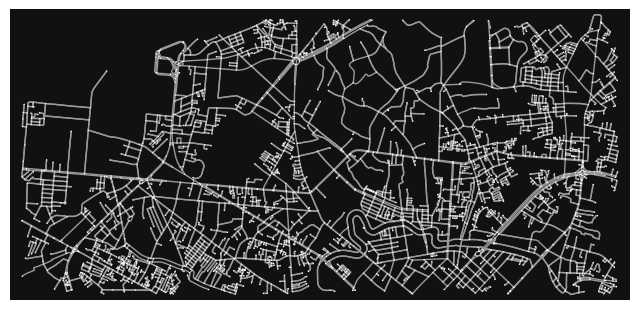

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [28]:
ox.plot.plot_graph(nx.MultiDiGraph(G), save=True, show=True, filepath='./graph.png', node_size=1)
# nx.draw(G)
# plt.savefig('graph.png', bbox_inches='tight')

In [29]:
plt.show()